# Evaluación de la segmentación 

| **Asignatura**           | **Integrantes:**               | **Fecha**|
|--------------------------|--------------------------------|----------|
| Percepción Computacional | Avila Ramírez Larissa Samantha |  28/05/25|
|                          | Hernández Terán Román          |          |

# Ground Truth

La **ground truth** es la referencia objetiva y verificada con la que se comparan las predicciones de un sistema para saber qué tan bien está funcionando.

Para validar la segmentación, tiene que haber una segmentación de referencia, lo que se denomina generalmente como un **ground truth**. Este ground truth se tiene que obtener de forma manual, pintando la silueta de los objetos de interés con un color uniforme.

A menudo, la obtención de estos ground truths se denomina _etiquetado manual de imágenes_ o, en este caso, _segmentación manual de imágenes_

En el aprendizaje automático y el análisis de datos, la ground truth actúa como una brújula que orienta los modelos hacia la fiabilidad, la precisión y la exhaustividad. Sin la ground truth, los modelos de IA pueden descarriarse y dar lugar a aplicaciones defectuosas y decisiones inadecuadas o sesgadas.

La ground truth no es estática; evoluciona con el tiempo, reflejando patrones y verdades cambiantes. Su naturaleza dinámica subraya su importancia, impulsando a los científicos e ingenieros de datos a refinar y validar continuamente sus datos de formación para que coincidan con las verdades actuales.

### ¿Por qué es Importante?

**Evaluación**: Se usa para comparar las predicciones del modelo con la verdad conocida y así medir precisión, recall, F1-score, etc.

**Entrenamiento supervisado**: El modelo aprende ajustando sus parámetros para que sus salidas coincidan lo más posible con el ground truth.

**Análisis de errores**: Ayuda a entender en qué casos el modelo falla o acierta.


> En detección de objetos, la **ground truth** son las anotaciones correctas (hechas por humanos) sobre qué objetos hay en la imagen y dónde están. Se usa para entrenar, validar y evaluar el rendimiento de los modelos.


# Métodos Tradicionales

## MSER (Maximally Stable Extremal Regions)

Es un algoritmo para detectar regiones estables en una imagen basada en variaciones de intensidad. Las *"regiones extremales"* son áreas conectadas cuyos píxeles tienen intensidades consistentemente más claras o más oscuras que sus bordes. Se llaman *"máximamente estables"* porque su forma y tamaño cambian muy poco al variar un umbral de intensidad.

### ¿Cómo funciona?

- **Explora múltiples umbrales**: Se convierte la imagen en una serie de imágenes binarias aplicando distintos umbrales de intensidad.

- **Detecta regiones conectadas**: En cada imagen binaria se detectan regiones conectadas (blobs).

- **Evalúa estabilidad**: Se mide cuánto cambia el área de una región entre umbrales consecutivos.

- **Selecciona regiones estables**: Aquellas que cambian muy poco entre varios umbrales se consideran MSERs.

- 

### Características de MSER

- **Invariante a escala y rotación**: Detecta las mismas regiones incluso si la imagen se escala o rota.

- **Robusto a cambios de iluminación.**

- **No requiere entrenamiento**: Es un método basado en umbrales y análisis de conectividad.


### Aplicaciones Comunes

- **Reconocimiento de texto**: Muy útil para detectar caracteres en imágenes naturales (OCR).

- **Emparejamiento de imágenes**: Se usa como detector de características junto con descriptores como SIFT o SURF.

- **Visión por computador en tiempo real**: Debido a su eficiencia y precisión.

### Ejemplo1: 

Supongamos que necesitamos automatizar la captura de texto en etiqetas de paquetes, los cuales van pasando por una banda.
Para este ejemplo, utilizaremos el reconocimiento de texto.

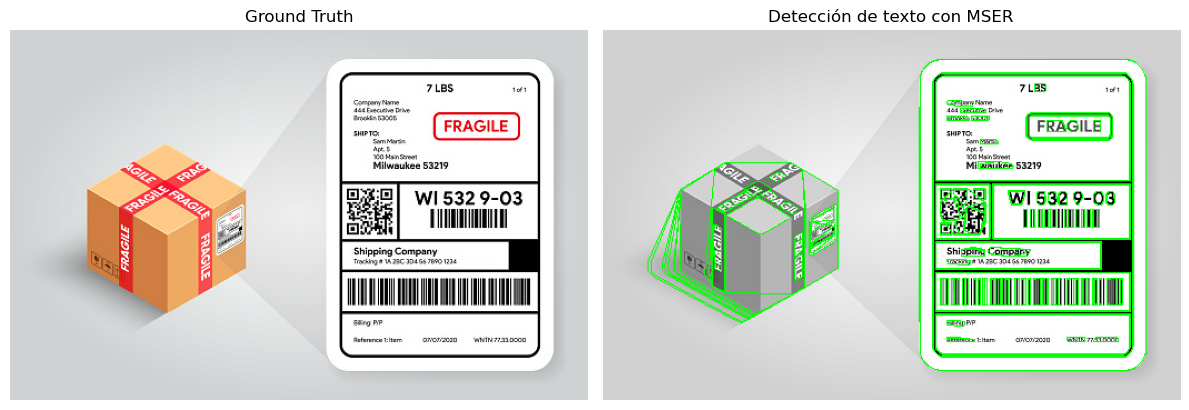

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Se carga una imagen para convertirla a escala de grises para que el reconocimiento de caracteres sea más preciso
imagen1 = cv2.imread('assets/label1.jpg', cv2.IMREAD_GRAYSCALE)

# Aquí se crea el MSER, la función toma de la librería CV2
mser = cv2.MSER_create()

# Detecta las regiones de la imagen precargada
regiones, _ = mser.detectRegions(imagen1)

# Ahora la imagen se pasa a color para comenzar a dibujar
imagen_color = cv2.cvtColor(imagen1, cv2.COLOR_GRAY2BGR)

# Aquí se comienzan a dibujar los contornos de las regiones detectadas
for region in regiones:
    contorno = cv2.convexHull(region.reshape(-1, 1, 2))
    cv2.polylines(imagen_color, [contorno], True, (0, 255, 0), 1)

# Ahora solo se pasa de formato BGR a RGB para la matplotlib
imagen_rgb = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB)


GROUND_TRUTH = plt.imread('assets/label1.jpg')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(GROUND_TRUTH)
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 2, 2)

plt.imshow(imagen_rgb)
plt.title("Detección de texto con MSER")
plt.axis("off")
plt.tight_layout()
plt.show()



### Ejemplo2

Ahora bien, supongamos que una vez que se han identificado los textos de las etiquetas de las cajas, queremos contar dichas cajas al terminar su recorrido en la banda.

Para esto, usaremo el método **Watershed**.

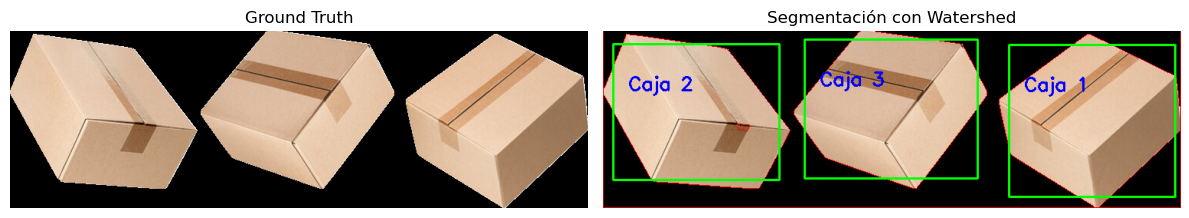

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carga de imagen (para este ejemplodebe tener fondo negro y figuras blancas)
imagen = cv2.imread('assets/boxes.png')
gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Binarización
_, binaria = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Sustracción de Ruido
kernel = np.ones((3, 3), np.uint8)
abierta = cv2.morphologyEx(binaria, cv2.MORPH_OPEN, kernel, iterations=2)

# Fondo estable
fondo_seguro = cv2.dilate(abierta, kernel, iterations=3)

# Primer plano: centro de las figuras
dist_transform = cv2.distanceTransform(abierta, cv2.DIST_L2, 5)
_, primer_plano = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)
primer_plano = np.uint8(primer_plano)

# Región desconocida
desconocido = cv2.subtract(fondo_seguro, primer_plano)

# Etiquetado de cada componente detectado
_, marcadores = cv2.connectedComponents(primer_plano)

marcadores = marcadores + 1
marcadores[desconocido == 255] = 0

# Ahora se puede aplicar Watershed
imagen_color = imagen.copy()
cv2.watershed(imagen_color, marcadores)

imagen_color[marcadores == -1] = [0, 0, 255]

# Dibujo de contornos y número de cada figura
contornos, _ = cv2.findContours(primer_plano, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contornos):
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(imagen_color, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(imagen_color, f"Caja {i+1}", (x+20, y+60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB))
plt.title("Segmentación con Watershed")
plt.axis("off")

plt.tight_layout()
plt.show()
